### Import Libraries

In [1]:
# Import libraries
import os 
import sys
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms
import json
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Image
import IPython.display as ipd
from tqdm import tqdm, tqdm_pandas
import random
import gc
import time
import pickle

### Read in data

In [2]:
Train_pt_DIR = './train_pt'
Train_Metadata_DIR = './train_metadata.csv'
Scored_Bird_DIR ='./scored_birds.json'
Train_DIR = './train_audio/'
Audio_Rating_Dir = "./bird_audio_rating_mapping.pkl"

#read in metadata as df
train_df = pd.read_csv(Train_Metadata_DIR)
train_df.head()
train_df['dir'] = Train_DIR+train_df['filename']
#print(train_df['dir'])
tqdm.pandas()
#train_df['spectogram'] = train_df.progress_apply(lambda x: process_audio_to_spectogram(x['dir']),axis=1)

In [3]:
'''
num_audio_files = train_df.shape[0]

spectograms_list = []
for i in tqdm(range(100)):
    current_bird = train_df.primary_label.loc[i]
    process_get_audio_chunks_images(train_df['dir'].iloc[i])
'''

"\nnum_audio_files = train_df.shape[0]\n\nspectograms_list = []\nfor i in tqdm(range(100)):\n    current_bird = train_df.primary_label.loc[i]\n    process_get_audio_chunks_images(train_df['dir'].iloc[i])\n"

In [4]:
def get_spectograms_from_file(idx):
    #get all the corresponding spectogram in np format
    bird = idx2bird[idx]
    pt_filepath = Train_pt_DIR+"/"+bird+".pt"
    x_train = torch.load(pt_filepath).view(-1,1,128,216)
    num_training_samples = x_train.shape[0]
    #y_train is one hot encoded vector per training sample
    y_train = torch.tensor(np.array([0]*len(all_birds))).view(1,-1)
    y_train[0,idx] = 1
    y_train = torch.cat([y_train]*num_training_samples)

    return x_train, y_train

In [5]:
def get_n_training_spectograms_from_file(idx, n_spectograms, TRAINING_VAL_SPLIT):
    #get n random spectogram (np format) of selected bird
    bird = idx2bird[idx]
    pt_filepath = Train_pt_DIR+"/"+bird+".pt"
    x_train = torch.load(pt_filepath).view(-1,1,128,216) # to convert to N,C, H, W format
    
    train_index = int(TRAINING_VAL_SPLIT*len(x_train)) #80:20 split for training and validation
    
    indices = torch.randint(0,train_index,(n_spectograms,)) #only sample from training pool
    selected_X_train = x_train[indices]
    
    y_train = torch.tensor(np.array([0]*len(all_birds))).view(1,-1)
    y_train[0,idx] = 1
    selected_y_train = torch.cat([y_train]*n_spectograms)
    
    return selected_X_train, selected_y_train

In [6]:
a = torch.load('./train_pt/hudgod.pt')
print(a.shape)
b = torch.load('./train_pt/redpha1.pt')
print(b.shape)

FileNotFoundError: [Errno 2] No such file or directory: './train_pt/hudgod.pt'

### Noise Reduction

In [7]:
def noise_reduction(y, sr, plot=True, th=0.3):
    from scipy.fft import fft, fftfreq, ifft
    
    SAMPLE_RATE = 1
    DURATION = len(y) / SAMPLE_RATE
    N = int(SAMPLE_RATE * DURATION)

    yf = fft(y)
    xf = fftfreq(N, 1 / SAMPLE_RATE)
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(24, 8))
        axes[0].plot(np.arange(len(y)), y)
        axes[0].set_title('Before Time-Domain')
        axes[1].plot(xf, np.abs(yf))
        axes[1].set_title('Before Frequency-Domain')
        plt.show()
    
    # Filtering Low-Pass
    new_yf = yf.copy()
    middle = len(y) / 2
    new_yf[int(middle - len(y) * th):int(middle + len(y) * th)] = 0
    new_y = ifft(new_yf)
    new_y = new_y.real
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(24, 8))
        axes[0].plot(np.arange(len(y)), new_y)
        axes[0].set_title('After Time-Domain')
        axes[1].plot(xf, np.abs(new_yf))
        axes[1].set_title('After Frequency-Domain')
        plt.show()

    return new_y, sr

### EDA

In [8]:
all_birds = list(train_df.primary_label.dropna().unique())
print('Total number of birds',len(all_birds))

Total number of birds 152


In [9]:
#for mapping of bird (str) to idx (int)
bird2idx = {}
for i, bird in enumerate(all_birds):
    bird2idx[bird] = i
    
idx2bird = {}
for _, (k, v) in enumerate(bird2idx.items()): 
    idx2bird[v] = k 

In [10]:
idx2bird[151]
bird2idx['zebdov']

151

Total number of birds 152
Scored birds ['akiapo', 'aniani', 'apapan', 'barpet', 'crehon', 'elepai', 'ercfra', 'hawama', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1', 'houfin', 'iiwi', 'jabwar', 'maupar', 'omao', 'puaioh', 'skylar', 'warwhe1', 'yefcan']
Number of scored birds training files 
 akiapo      14
aniani      12
apapan      47
barpet      15
crehon       2
elepai      14
ercfra       6
hawama      21
hawcre      20
hawgoo       9
hawhaw       3
hawpet1      3
houfin     322
iiwi        37
jabwar      78
maupar       1
omao        21
puaioh       3
skylar     500
warwhe1     71
yefcan      67
Name: primary_label, dtype: int64

Number of training files per bird


<AxesSubplot:>

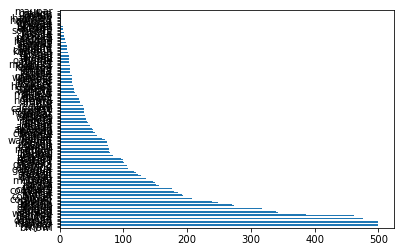

In [11]:
all_birds = list(train_df.primary_label.dropna().unique())
print('Total number of birds',len(all_birds))

#load scored birds 
with open(Scored_Bird_DIR) as sbfile:
    scored_birds = json.load(sbfile)
print('Scored birds',scored_birds)

bird_training_sample = train_df.primary_label.value_counts()

print('Number of scored birds training files \n',bird_training_sample.loc[scored_birds])
print()
print('Number of training files per bird')
bird_training_sample.plot(kind='barh')


In [12]:
#EDA, did the number of training data (5s) per bird
num_training_data = {}
for bird in tqdm(all_birds):
    _, y_train_bird = get_spectograms_from_file(bird2idx[bird])
    num_training_data[bird] = len(y_train_bird)
sorted_training_data = sorted(num_training_data.items(), key = lambda kv: kv[1])
print(sorted_training_data)

scored_bird_training = {}
for bird in tqdm(scored_birds):
    scored_bird_training[bird] = num_training_data[bird]
sorted_scored_bird_training_data = sorted(scored_bird_training.items(), key = lambda kv: kv[1])
print(sorted_scored_bird_training_data)

  0%|          | 0/152 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: './train_pt/afrsil1.pt'

In [13]:
x, y = zip(*sorted_training_data) 
plt.plot(x, y)
plt.show()

x, y = zip(*sorted_scored_bird_training_data) 
plt.plot(x, y)
plt.show()

NameError: name 'sorted_training_data' is not defined

### Generate training data in .pt

In [14]:
def get_spectograms(filename):
    chunk_duration = 5 #5sec chunk
    duration = librosa.get_duration(filename=filename)
    num_spectogram = int(duration/chunk_duration)
    spectograms = []
    for i in range(num_spectogram):
        y, sr = librosa.load(filename, offset=i*chunk_duration, duration=chunk_duration)
        #display("Old Audio", ipd.Audio(data=y, rate=sr))
        nr_y, nr_sr = noise_reduction(y, sr, plot=False, th=0.3)
        #display("New Audio", ipd.Audio(data=nr_y, rate=sr))
        S = librosa.feature.melspectrogram(y=nr_y, sr=nr_sr)
        S_DB = librosa.power_to_db(S, ref=np.max)
        spectograms.append(S_DB)
    return spectograms

In [ ]:
#generate pt files
num_audio_files = train_df.shape[0]

spectograms_list = []
for i in tqdm(range(num_audio_files)):
    current_bird = train_df.primary_label.loc[i]
    #print('previous_bird',previous_bird)
    #print('current_bird',current_bird)
    spectograms_list += get_spectograms(train_df['dir'].iloc[i])
    if i+1 == num_audio_files:
        torch.save(torch.tensor(np.array(spectograms_list)), './train_pt/'+current_bird+'.pt')
    else:
        next_bird = train_df.primary_label.loc[i+1]
        #print('next_bird',next_bird)
        if next_bird != current_bird:
            torch.save(torch.tensor(np.array(spectograms_list)), './train_pt/'+current_bird+'.pt')
            spectograms_list = []
    previous_bird = current_bird
    #print(spectograms_list[0])

 11%|█▏        | 1674/14852 [28:06<42:04:30, 11.49s/it]

### Get the audio rating for each of the training sample

In [ ]:
'''
num_audio_files = train_df.shape[0]

def get_num_spectograms_per_audio(filename):
    chunk_duration = 5 #5sec chunk
    duration = librosa.get_duration(filename=filename)
    num_spectogram = int(duration/chunk_duration)
    
    return num_spectogram

bird_audio_rating_mapping = {}
audio_rating_list = []
for i in tqdm(range(num_audio_files)):
    current_bird = train_df.primary_label.loc[i]
    audio_rating = train_df['rating'].iloc[i]
    if audio_rating == 0:
        audio_rating = 2.5
    num_spec = get_num_spectograms_per_audio(train_df['dir'].iloc[i])
    audio_rating_list += [audio_rating]*num_spec
    if i+1 == num_audio_files:
        bird_audio_rating_mapping[current_bird] = audio_rating_list
        #torch.save(torch.tensor(np.array(spectograms_list)), './train_pt/'+current_bird+'.pt')
    else:
        next_bird = train_df.primary_label.loc[i+1]
        if next_bird != current_bird:
            bird_audio_rating_mapping[current_bird] = audio_rating_list
            #torch.save(torch.tensor(np.array(spectograms_list)), './train_pt/'+current_bird+'.pt')
            audio_rating_list = []
    previous_bird = current_bird

#save the mapping into file
rating_file = open("bird_audio_rating_mapping.pkl", "wb")
pickle.dump(bird_audio_rating_mapping, rating_file)
rating_file.close()'''

In [ ]:
rating_file = open(Audio_Rating_Dir, "rb")
bird_audio_rating_mapping = pickle.load(rating_file)
#print(bird_audio_rating_mapping)
rating_file.close()

In [ ]:
print(bird_audio_rating_mapping['blknod'])
print(len(bird_audio_rating_mapping['blknod']))
print((num_training_data['blknod']))

### Training

In [ ]:
training_seq = [i for i in range(len(all_birds))]
random.shuffle(training_seq)
print(training_seq)
print()
training_seq_bird = [idx2bird[i] for i in training_seq]
print(training_seq_bird)

### Model

In [ ]:
torch.cuda.empty_cache()
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(t)
print(r)
print(a)
print(f)

In [ ]:
# For upsampling / downsampling / mixup of data
TRAINING_THRESHOLD_UPSAMPLING = 512
TRAINING_THRESHOLD_DOWNSAMPLING = 512 * 2
TRAINING_MIXUP_PERCENTAGE = 0.2 #0.2 means 20% of the training data (after up and down sampling) will be mixup 
TRAINING_SPECAUGMENT_PERCENTAGE = 0.2 #0.2 means 20% of the training data (after up and down sampling) will be spec-augment 
TRAINING_VAL_SPLIT = 0.8 #0.8 means 80% of training data will be considered for training, 20% for validation (untouched)

def get_more_samples_raw(X_train_bird,y_train_bird,additional_num_samples,rating_weights):
    #x train
    #e.g. i need 512, but i only have 500
    #total_samples = len(y_train_bird)
    indices = torch.multinomial(rating_weights,additional_num_samples,replacement=True) #generate the random index, 
    #e.g. [0,99,54,46,56,35,245,6,8,8,2]
    #indices = torch.randint(0,total_samples,(additional_num_samples,))

    additional_X_train_bird = X_train_bird[indices]
    additional_y_train_bird = y_train_bird[indices]
    
    return additional_X_train_bird, additional_y_train_bird

def get_down_samples(X_train_bird,y_train_bird,num_samples,rating_weights):
    #x train
    # i got 2000 samples, retrieve only 1024
    indices = torch.multinomial(rating_weights,num_samples)

    updated_X_train_bird = X_train_bird[indices]
    updated_y_train_bird = y_train_bird[indices]
    
    return updated_X_train_bird, updated_y_train_bird

def get_mixup_samples(X_train_bird,y_train_bird,num_mixup_sample,rating_weights,TRAINING_VAL_SPLIT):
    
    #randomly select indices from bird type 1
    source_indices = torch.randint(0,len(y_train_bird),(num_mixup_sample,))
    source_X_train = X_train_bird[source_indices]
    source_y_train = y_train_bird[source_indices]

    #--- TARGET BIRD ---
    #randomly select target bird type to mixup
    target_bird = torch.randint(0,len(all_birds),(num_mixup_sample,)) #output [10,4,7,64,32]
    bird_count = torch.bincount(target_bird) # output from bird1 - 4 times, bird 2 - 20 times 
    
    #initialise empty tensor
    target_X_train = torch.empty(0,X_train_bird.shape[1],X_train_bird.shape[2],X_train_bird.shape[3]) # N, C , H, W
    target_y_train = torch.empty(0,len(all_birds))
    for i in range(len(bird_count)):
        if bird_count[i] >0:
            add_target_X_train, add_target_y_train = get_n_training_spectograms_from_file(i, bird_count[i],TRAINING_VAL_SPLIT) #touched val_data, to be revised
            target_X_train = torch.cat((target_X_train,add_target_X_train),0)
            target_y_train = torch.cat((target_y_train,add_target_y_train),0)
    
    #Perform Mixup for source and target bird entries
    mixup_X_train = torch.zeros(num_mixup_sample,X_train_bird.shape[1],X_train_bird.shape[2],X_train_bird.shape[3])
    mixup_y_train = torch.zeros_like(target_y_train)
    for i in range(len(source_indices)):
        lambda_factor = torch.randn(1) 
        mixup_X_train[i] = source_X_train[i]*lambda_factor + target_X_train[i]*(1-lambda_factor)
        mixup_y_train[i] = source_y_train[i]*lambda_factor + target_y_train[i]*(1-lambda_factor)

    return mixup_X_train, mixup_y_train

def spec_augment(spec, num_mask=1, 
                 freq_masking_max_percentage=0.1, time_masking_max_percentage=0.1):
    
    spec = spec.detach().clone()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

def get_specaugment_samples(X_train_bird,y_train_bird,num_specaugment_sample,rating_weights):
    source_indices = torch.randint(0,len(y_train_bird),(num_specaugment_sample,))
    specaugment_X_train = X_train_bird[source_indices]
    specaugment_y_train = y_train_bird[source_indices]
    
    for i in range(num_specaugment_sample):
        specaugment_X_train[i] = spec_augment(specaugment_X_train[i].squeeze()).view(1,X_train_bird.shape[2],X_train_bird.shape[3])

    return specaugment_X_train, specaugment_y_train

In [ ]:
def train_model(model, criterion, optimizer, num_epochs, batch_size, training_seq):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in (range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        random.shuffle(training_seq)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            #print(phase)
            
            running_loss = 0.0
            running_corrects = 0
            dataset_size =0
        
            for bird_idx in tqdm(training_seq):
                X_bird, y_bird = get_spectograms_from_file(bird_idx) #get all training data for each bird
                #split to train and val set 
                
                train_index = int(TRAINING_VAL_SPLIT*len(y_bird)) #80:20 split for training and validation
                if phase == 'train':
                    #print('bird', idx2bird[bird_idx])
                    #print('shape b4',X_bird.shape)
                    X_train_bird = X_bird[0:train_index]
                    y_train_bird = y_bird[0:train_index]
                    
                    bird = idx2bird[bird_idx] #get the rating weights for sampling
                    rating_audio = bird_audio_rating_mapping[bird] #higher rating audio will have higher chance of being sampled
                    rating_audio_tensor = torch.tensor(np.array(rating_audio))
                    rating_weights = rating_audio_tensor[0:train_index]
                    #print('shape 1',X_bird.shape)
                    #upsampling and downsampling for each bird
                    if len(y_train_bird) < TRAINING_THRESHOLD_UPSAMPLING:
                        additional_num_samples = TRAINING_THRESHOLD_UPSAMPLING - len(y_train_bird) 
                        additional_X_train_bird, additional_y_train_bird = get_more_samples_raw(X_train_bird,y_train_bird,additional_num_samples,rating_weights)
                        X_train_bird = torch.cat((X_train_bird,additional_X_train_bird),0)
                        y_train_bird = torch.cat((y_train_bird,additional_y_train_bird),0)
                        #print('upsampling completed for ',idx2bird[bird_idx])
                    elif len(y_train_bird) > TRAINING_THRESHOLD_DOWNSAMPLING:
                        X_train_bird, y_train_bird = get_down_samples(X_train_bird,y_train_bird,TRAINING_THRESHOLD_DOWNSAMPLING,rating_weights)
                        #print('downsampling completed for ',idx2bird[bird_idx])
                    
                    #print('shape 2',X_bird.shape)
                    #perform mixup for each bird
                    if TRAINING_MIXUP_PERCENTAGE > 0:
                        #generate additional sample
                        num_mixup_sample = int(len(y_train_bird) * TRAINING_MIXUP_PERCENTAGE)
                        mixup_X_train_bird, mixup_y_train_bird = get_mixup_samples(X_train_bird,y_train_bird,num_mixup_sample,rating_weights,TRAINING_VAL_SPLIT)
                        #print('mixup completed for ',idx2bird[bird_idx])
                    
                    if TRAINING_SPECAUGMENT_PERCENTAGE >0:
                        num_specaugment_sample = int(len(y_train_bird) * TRAINING_SPECAUGMENT_PERCENTAGE)
                        specaugment_X_train_bird, specaugment_y_train_bird = get_specaugment_samples(X_train_bird,y_train_bird,num_specaugment_sample,rating_weights)
                        #print('specaugment_X_train_bird.shape',specaugment_X_train_bird.shape)
                        
                    if TRAINING_MIXUP_PERCENTAGE > 0:
                        #add the generated samples
                        X_train_bird = torch.cat((X_train_bird,mixup_X_train_bird),0)
                        y_train_bird = torch.cat((y_train_bird,mixup_y_train_bird),0)
                    
                    if TRAINING_SPECAUGMENT_PERCENTAGE > 0:
                        #add the generated samples
                        X_train_bird = torch.cat((X_train_bird,specaugment_X_train_bird),0)
                        y_train_bird = torch.cat((y_train_bird,specaugment_y_train_bird),0)
                        
                    #e.g.     X_train_bird.shape = (640,1,128,216)
                    dataset_size += len(y_train_bird)
                else:
                    X_train_bird = X_bird[train_index:]
                    y_train_bird = y_bird[train_index:]
                    dataset_size += (len(y_bird)-train_index-1)
                
                num_batch = -(-len(y_train_bird)//batch_size) #e.g.10
                for batch in (range(num_batch)):
                    X_train = X_train_bird[batch*batch_size : (batch+1)*batch_size]
                    y_train = y_train_bird[batch*batch_size : (batch+1)*batch_size]
                    X_train = X_train.to(device)
                    y_train = y_train.to(device)
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(X_train)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, y_train.type(torch.float))
                    
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # statistics
                    running_loss += loss.item() * X_train.size(0)
                    _,ground_truth = torch.max(y_train, 1)
                    running_corrects += torch.sum(preds == ground_truth)
                    
                    #clear memory
                    del X_train
                    del y_train
                    gc.collect()
                    torch.cuda.empty_cache()

                    
            #statistics
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            time_elapsed = time.time() - since
            print(f'Time_elapsed {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            
             # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), './last_model_parameters.pt')
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# MODEL = 'resnet'
MODEL = 'vit'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

if MODEL == 'resnet':
    model = models.resnet50(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, len(all_birds))
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model = model.to(device)
    
    batch_size = 64
    

if MODEL == 'vit':
    
    efficient_transformer = Linformer(
        dim=216,
        seq_len=27649, # 128 * 216 + 1 cls token
        depth=12,
        heads=8,
        k=64
        )
    
    vit_model = ViT(
        image_size=216,
        patch_size=1,
        num_classes=len(training_seq),
        dim=216,
        transformer=efficient_transformer,
        channels=1
        ).to(device)
    
    model = vit_model    
    batch_size = 192    
    
#     LR = 0.001
#     GAMMA = 0.7 #for learning rate scheduler 
#     scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)

num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=1)

#model.load_state_dict(torch.load('./last_model_parameters.pt'))
best_model = train_model(model, criterion, optimizer, num_epochs, batch_size, training_seq)

In [ ]:
torch.save(model.state_dict(), './best_model_parameters.pt')

#model.load_state_dict(torch.load('./best_model_parameters.pt'))
model.load_state_dict(torch.load('./last_model_parameters.pt'))

In [ ]:
Test_Audio_DIR = './test_soundscapes/'
file_list = [f.split('.')[0] for f in sorted(os.listdir(Test_Audio_DIR))]

print('Number of test soundscapes', len(file_list))

In [ ]:
pred = {'row_id': [], 'target': []}
threshold = 0.3
model.eval() 

for file in file_list:
    test_audio_file_path = test_audio_dir + file + '.ogg'
    
    chunk_duration = 5 #5sec chunk
    duration = librosa.get_duration(filename=test_audio_file_path)
    num_spectogram = int(duration/chunk_duration)
    
    chunks = [[] for i in range(num_spectogram)]

    melspec_test = torch.tensor(get_spectograms(test_audio_file_path)).view(-1,1,128,216)
    #X_test = torch.stack(melspec_test).to(device)
    X_test = (melspec_test).to(device)
    #print(X_test.shape)

    outputs = model(X_test)
    #print(outputs.shape)
    outputs_test = torch.sigmoid(outputs)
    #print(outputs_test.shape)
    #print(scored_birds)

    for idx, i in enumerate(range(len(chunks))):
        chunk_end_time = (i + 1) * 5
        for bird in scored_birds:
            try:
                score = outputs_test[idx][bird2idx[bird]]
            except IndexError:
                score = 0
            
            row_id = file + '_' + bird + '_' + str(chunk_end_time)
            #print('score is ', score)
            pred['row_id'].append(row_id)
            pred['target'].append(True if score > threshold else False)

In [ ]:
results = pd.DataFrame(pred, columns = ['row_id', 'target'])
print(results)

results.to_csv("submission.csv", index=False)